In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from rich import print
from sklearn import preprocessing

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
root = '..\\CICIoT2023'

fName = []
for f in glob(f'{root}\\*.csv'):
    fName.append(f)
    
train_df = pd.read_csv(fName[0])
test_df  = pd.read_csv(fName[1])
valid_df = pd.read_csv(fName[2])
train_df2 = pd.read_csv(fName[3])

train_df = pd.concat([train_df, train_df2], axis = 0)

#map label(string) into label(int)
label_map = {}
i = 0
for label in train_df['label'].unique():
    label_map[label] = i
    i += 1
    
print(label_map)
train_df['label'] = train_df['label'].map(label_map)
test_df['label']  = test_df['label'].map(label_map)
valid_df['label'] = valid_df['label'].map(label_map)

#split data
train_data  = train_df.iloc[:, 0 : -1]
train_label = train_df.iloc[:, -1]
test_data  = test_df.iloc[:, 0 : -1]
test_label = test_df.iloc[:, -1]
valid_data  = valid_df.iloc[:, 0 : -1]
valid_label = valid_df.iloc[:, -1]

n_train_data = preprocessing.scale(train_data)
n_valid_data = preprocessing.scale(valid_data)
n_test_data  = preprocessing.scale(test_data)

n_train_data = pd.DataFrame(n_train_data)
n_valid_data = pd.DataFrame(n_valid_data)
n_test_data  = pd.DataFrame(n_test_data)

{
    'DDoS-RSTFINFlood': 0,
    'DoS-TCP_Flood': 1,
    'DDoS-ICMP_Flood': 2,
    'DoS-UDP_Flood': 3,
    'DoS-SYN_Flood': 4,
    'Mirai-greeth_flood': 5,
    'DDoS-SynonymousIP_Flood': 6,
    'Mirai-udpplain': 7,
    'DDoS-SYN_Flood': 8,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'BenignTraffic': 12,
    'MITM-ArpSpoofing': 13,
    'DDoS-ACK_Fragmentation': 14,
    'Mirai-greip_flood': 15,
    'DoS-HTTP_Flood': 16,
    'DDoS-ICMP_Fragmentation': 17,
    'Recon-PortScan': 18,
    'DNS_Spoofing': 19,
    'DDoS-UDP_Fragmentation': 20,
    'Recon-OSScan': 21,
    'XSS': 22,
    'DDoS-HTTP_Flood': 23,
    'Recon-HostDiscovery': 24,
    'CommandInjection': 25,
    'VulnerabilityScan': 26,
    'DDoS-SlowLoris': 27,
    'Backdoor_Malware': 28,
    'BrowserHijacking': 29,
    'DictionaryBruteForce': 30,
    'SqlInjection': 31,
    'Recon-PingSweep': 32,
    'Uploading_Attack': 33
}

C:\Users\SoraNyan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\SoraNyan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [4]:
class myDataset(Dataset):
    def __init__(self, data, label):
        super(myDataset, self).__init__()
        self.data = data
        self.label = label
        
    def __len__(self):
        return self.data.shape[0]
        
    def __getitem__(self, index):
        return torch.tensor(self.data.iloc[index].values, dtype = torch.float32), torch.tensor(self.label.iloc[index], dtype = torch.long)

In [5]:
train_set = myDataset(n_train_data, train_label)
valid_set = myDataset(n_valid_data, valid_label)
test_set  = myDataset(n_test_data, test_label)

print(train_set.__len__())
print(valid_set.__len__())
print(test_set.__len__())

train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = 128, shuffle = False)
test_loader  = DataLoader(test_set , batch_size = 128, shuffle = False)

469710

275258

218805

In [6]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.embed   = nn.Linear(46, 256)
        self.bNorm   = nn.BatchNorm1d(256)
        self.layer   = nn.TransformerEncoderLayer(d_model = 256, nhead = 16, batch_first = True)
        self.encoder = nn.TransformerEncoder(self.layer, num_layers = 8)
        self.linear1 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        self.out = nn.Linear(1024, 34)
        
    def forward(self, x):
        x = self.embed(x)
        x = self.bNorm(x)
        x = self.encoder(x)
        x = self.drop1(F.relu(self.linear1(x)))
        x = self.drop2(F.relu(self.linear2(x)))
        x = self.out(x)
        return x

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(46, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, 34)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.out(x)

In [8]:
teacher_model = Transformer().to(device)
teacher_optim = torch.optim.Adam(teacher_model.parameters(), lr = 1e-4, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(teacher_optim, step_size = 20, gamma = 0.1)
loss_func = torch.nn.CrossEntropyLoss()
teacher_epoch = 150

# 訓練大模型(teacher model)

In [9]:
def train_teacher(model, optim, loss_func, train_loader, valid_loader, epoch):
    train_loss = []
    train_acc  = []
    valid_loss = []
    valid_acc  = []
    best_t = 100
    best_v = 100
    for e in range(epoch):
        train_epoch_acc  = 0
        valid_epoch_acc  = 0
        train_epoch_loss = 0
        valid_epoch_loss = 0
        total_train = 0
        total_valid = 0
        
        model.train()
        for (data, label) in tqdm(train_loader, desc = 'training'):
            data  = data.to(device)
            label = label.to(device)
            
            optim.zero_grad()
            pred = model(data)
            loss = loss_func(pred, label)
            loss.backward()
            optim.step()
            
            train_epoch_acc += (torch.argmax(pred, axis = 1) == label).sum()
            train_epoch_loss += loss.item()
            total_train += data.shape[0]
        scheduler.step()
        train_loss.append(train_epoch_loss / len(train_loader))
        train_acc.append(train_epoch_acc.item() / total_train)
            
        model.eval()
        with torch.no_grad():
            for (data, label) in tqdm(valid_loader, desc = 'validating'):
                data  = data.to(device)
                label = label.to(device)

                pred = model(data)
                loss = loss_func(pred, label)
                valid_epoch_acc += (torch.argmax(pred, axis = 1) == label).sum()
                valid_epoch_loss += loss.item()
                total_valid += data.shape[0]
            valid_loss.append(valid_epoch_loss / len(valid_loader))
            valid_acc.append(valid_epoch_acc.item() / total_valid)
            
        print(f'epoch {e} | train_loss {train_loss[-1]:.6f} train_acc {train_acc[-1]:.6f} valid_loss {valid_loss[-1]:.6f} valid_acc {valid_acc[-1]:.6f}')
        
        if train_loss[-1] < best_t and valid_loss[-1] < best_v:
            best_t = train_loss[-1]
            best_v = valid_loss[-1]
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optim_state_dict' : optim.state_dict()
            }, 'teacher\\checkpoint.pth')
    return train_loss, train_acc, valid_loss, valid_acc

In [10]:
teach_train_mode = False
load_best_model = False

if teach_train_mode:
    t_train_loss, t_train_acc, t_valid_loss, t_valid_acc = train_teacher(teacher_model, teacher_optim, loss_func, train_loader, valid_loader, teacher_epoch)
    torch.save(teacher_model.state_dict(), 'final_teacher_model.pth')
else:
    if load_best_model:
        checkpoint = torch.load('teacher\\checkpoint.pth')
        teacher_model.load_state_dict(checkpoint['model_state_dict'])
    else:
        state_dict = torch.load('final_teacher_model.pth')
        teacher_model.load_state_dict(state_dict)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

if teach_train_mode:
    x = np.linspace(0, len(t_train_loss), len(t_train_loss))
    plt.clf()
    plt.plot(x, t_train_loss, label = 'train_loss')
    plt.plot(x, t_valid_loss, label = 'valid_loss')

    plt.legend()
    plt.show()

In [12]:
if teach_train_mode:
    x = np.linspace(0, len(t_train_acc), len(t_train_acc))
    plt.clf()
    plt.plot(x, t_train_acc, label = 'train_acc')
    plt.plot(x, t_valid_acc, label = 'valid_acc')

    plt.legend()
    plt.show()

# 訓練小模型 (student model)

In [13]:
student_model = MLP().to(device)
student_optim = torch.optim.Adam(student_model.parameters(), lr = 1e-4)
loss_func2 = nn.KLDivLoss(reduction = 'batchmean')
student_epoch = 100

In [14]:
def train_student(t_model, s_model, optim, loss_func1, loss_func2, train_loader, valid_loader, epoch):
    train_loss = []
    train_acc  = []
    valid_loss = []
    valid_acc  = []
    best_t = 100
    best_v = 100
    for e in range(epoch):
        train_epoch_acc  = 0
        valid_epoch_acc  = 0
        train_epoch_loss = 0
        valid_epoch_loss = 0
        total_train = 0
        total_valid = 0
        
        s_model.train()
        t_model.eval()
        for (data, label) in tqdm(train_loader, desc = 'training'):
            data  = data.to(device)
            label = label.to(device)
            
            optim.zero_grad()
            t_pred = t_model(data)
            s_pred = s_model(data)
            CELoss = loss_func1(s_pred, label)
            KLDiv  = loss_func2(F.log_softmax(s_pred, dim = 1), F.softmax(t_pred, dim = 1))
            loss = 0.5 * CELoss + 0.5 * KLDiv
            loss.backward()
            optim.step()
            
            train_epoch_acc += (torch.argmax(s_pred, axis = 1) == label).sum()
            train_epoch_loss += loss.item()
            total_train += data.shape[0]
        train_loss.append(train_epoch_loss / len(train_loader))
        train_acc.append(train_epoch_acc.item() / total_train)
            
        s_model.eval()
        with torch.no_grad():
            for (data, label) in tqdm(valid_loader, desc = 'validating'):
                data  = data.to(device)
                label = label.to(device)

                t_pred = t_model(data)
                s_pred = s_model(data)
                CELoss = loss_func1(s_pred, label)
                KLDiv  = loss_func2(F.log_softmax(s_pred, dim = 1), F.softmax(t_pred, dim = 1))
                loss = 0.5 * CELoss + 0.5 * KLDiv
                valid_epoch_acc += (torch.argmax(s_pred, axis = 1) == label).sum()
                valid_epoch_loss += loss.item()
                total_valid += data.shape[0]
            valid_loss.append(valid_epoch_loss / len(valid_loader))
            valid_acc.append(valid_epoch_acc.item() / total_valid)
            
        print(f'epoch {e} | train_loss {train_loss[-1]:.6f} train_acc {train_acc[-1]:.6f} valid_loss {valid_loss[-1]:.6f} valid_acc {valid_acc[-1]:.6f}')
        
        if train_loss[-1] < best_t and valid_loss[-1] < best_v:
            best_t = train_loss[-1]
            best_v = valid_loss[-1]
            torch.save({
                'model_state_dict' : s_model.state_dict(),
                'optim_state_dict' : optim.state_dict()
            }, 'student\\checkpoint.pth')
    return train_loss, train_acc, valid_loss, valid_acc

In [15]:
s_train_loss, s_train_acc, s_valid_loss, s_valid_acc = train_student(teacher_model, student_model, student_optim, loss_func, loss_func2, train_loader, valid_loader, teacher_epoch)
torch.save(student_model.state_dict(), 'final_student_model.pth')

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.51it/s]


epoch 0 | train_loss 0.492473 train_acc 0.791092 valid_loss 0.410590 valid_acc 0.804627

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 69.20it/s]


epoch 1 | train_loss 0.391384 train_acc 0.815631 valid_loss 0.381351 valid_acc 0.813324

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.39it/s]


epoch 2 | train_loss 0.356712 train_acc 0.837295 valid_loss 0.333663 valid_acc 0.855743

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.58it/s]


epoch 3 | train_loss 0.291656 train_acc 0.875766 valid_loss 0.266760 valid_acc 0.883680

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.97it/s]


epoch 4 | train_loss 0.224314 train_acc 0.908371 valid_loss 0.190990 valid_acc 0.919232

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.74it/s]


epoch 5 | train_loss 0.163257 train_acc 0.941455 valid_loss 0.150115 valid_acc 0.949604

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.89it/s]


epoch 6 | train_loss 0.111157 train_acc 0.962183 valid_loss 0.094417 valid_acc 0.968713

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.21it/s]


epoch 7 | train_loss 0.079125 train_acc 0.970869 valid_loss 0.077281 valid_acc 0.968760

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.81it/s]


epoch 8 | train_loss 0.064097 train_acc 0.974748 valid_loss 0.064391 valid_acc 0.977032

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.73it/s]


epoch 9 | train_loss 0.055036 train_acc 0.977784 valid_loss 0.050583 valid_acc 0.979812

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.32it/s]


epoch 10 | train_loss 0.049220 train_acc 0.979726 valid_loss 0.047275 valid_acc 0.980011

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.36it/s]


epoch 11 | train_loss 0.043651 train_acc 0.981633 valid_loss 0.046343 valid_acc 0.981668

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 69.20it/s]


epoch 12 | train_loss 0.041099 train_acc 0.982545 valid_loss 0.042137 valid_acc 0.982551

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 69.17it/s]


epoch 13 | train_loss 0.040275 train_acc 0.982594 valid_loss 0.090195 valid_acc 0.966660

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 69.14it/s]


epoch 14 | train_loss 0.038382 train_acc 0.983064 valid_loss 0.038106 valid_acc 0.982987

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.45it/s]


epoch 15 | train_loss 0.037218 train_acc 0.983281 valid_loss 0.040720 valid_acc 0.982053

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.43it/s]


epoch 16 | train_loss 0.038696 train_acc 0.983168 valid_loss 0.039240 valid_acc 0.983612

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.70it/s]


epoch 17 | train_loss 0.035620 train_acc 0.983875 valid_loss 0.036262 valid_acc 0.983779

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.92it/s]


epoch 18 | train_loss 0.034376 train_acc 0.984099 valid_loss 0.037066 valid_acc 0.983637

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.63it/s]


epoch 19 | train_loss 0.033933 train_acc 0.984212 valid_loss 0.034564 valid_acc 0.983833

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.55it/s]


epoch 20 | train_loss 0.032739 train_acc 0.984588 valid_loss 0.044498 valid_acc 0.977127

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.90it/s]


epoch 21 | train_loss 0.032430 train_acc 0.984784 valid_loss 0.040836 valid_acc 0.978130

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.58it/s]


epoch 22 | train_loss 0.033455 train_acc 0.984429 valid_loss 0.034604 valid_acc 0.984433

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.61it/s]


epoch 23 | train_loss 0.030672 train_acc 0.985189 valid_loss 0.041020 valid_acc 0.976502

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.80it/s]


epoch 24 | train_loss 0.030966 train_acc 0.985138 valid_loss 0.038117 valid_acc 0.983942

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.86it/s]


epoch 25 | train_loss 0.030479 train_acc 0.985304 valid_loss 0.034389 valid_acc 0.984059

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.55it/s]


epoch 26 | train_loss 0.034612 train_acc 0.984505 valid_loss 0.033938 valid_acc 0.984687

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.58it/s]


epoch 27 | train_loss 0.028937 train_acc 0.985879 valid_loss 0.034894 valid_acc 0.984789

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.69it/s]


epoch 28 | train_loss 0.029606 train_acc 0.985538 valid_loss 0.033831 valid_acc 0.983975

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.55it/s]


epoch 29 | train_loss 0.029070 train_acc 0.985776 valid_loss 0.032084 valid_acc 0.984912

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.59it/s]


epoch 30 | train_loss 0.029347 train_acc 0.985825 valid_loss 0.061685 valid_acc 0.978137

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.74it/s]


epoch 31 | train_loss 0.027767 train_acc 0.986306 valid_loss 0.032848 valid_acc 0.984378

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.74it/s]


epoch 32 | train_loss 0.029417 train_acc 0.985776 valid_loss 0.032035 valid_acc 0.985141

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.56it/s]


epoch 33 | train_loss 0.027745 train_acc 0.986411 valid_loss 0.031401 valid_acc 0.985043

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.60it/s]


epoch 34 | train_loss 0.027395 train_acc 0.986417 valid_loss 0.032804 valid_acc 0.984596

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.85it/s]


epoch 35 | train_loss 0.027094 train_acc 0.986407 valid_loss 0.033971 valid_acc 0.984233

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.69it/s]


epoch 36 | train_loss 0.026898 train_acc 0.986534 valid_loss 0.031985 valid_acc 0.984538

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.56it/s]


epoch 37 | train_loss 0.026623 train_acc 0.986762 valid_loss 0.035398 valid_acc 0.983782

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.71it/s]


epoch 38 | train_loss 0.026626 train_acc 0.986724 valid_loss 0.032070 valid_acc 0.984723

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.60it/s]


epoch 39 | train_loss 0.025798 train_acc 0.986883 valid_loss 0.041698 valid_acc 0.981541

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.39it/s]


epoch 40 | train_loss 0.026376 train_acc 0.986915 valid_loss 0.030604 valid_acc 0.985236

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.77it/s]


epoch 41 | train_loss 0.025386 train_acc 0.987311 valid_loss 0.031397 valid_acc 0.985192

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.56it/s]


epoch 42 | train_loss 0.025272 train_acc 0.987292 valid_loss 0.030605 valid_acc 0.985076

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.09it/s]


epoch 43 | train_loss 0.024727 train_acc 0.987330 valid_loss 0.031439 valid_acc 0.984785

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.94it/s]


epoch 44 | train_loss 0.024664 train_acc 0.987499 valid_loss 0.032591 valid_acc 0.984596

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.54it/s]


epoch 45 | train_loss 0.024700 train_acc 0.987522 valid_loss 0.031723 valid_acc 0.984789

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.63it/s]


epoch 46 | train_loss 0.024363 train_acc 0.987612 valid_loss 0.030395 valid_acc 0.985490

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.34it/s]


epoch 47 | train_loss 0.023925 train_acc 0.987714 valid_loss 0.029908 valid_acc 0.985515

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 68.47it/s]


epoch 48 | train_loss 0.024034 train_acc 0.987748 valid_loss 0.029926 valid_acc 0.985450

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 67.34it/s]


epoch 49 | train_loss 0.023561 train_acc 0.987948 valid_loss 0.030458 valid_acc 0.985762

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:31<00:00, 67.93it/s]


epoch 50 | train_loss 0.023836 train_acc 0.987829 valid_loss 0.030768 valid_acc 0.985061

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.41it/s]


epoch 51 | train_loss 0.022852 train_acc 0.988274 valid_loss 0.030960 valid_acc 0.985366

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.52it/s]


epoch 52 | train_loss 0.023482 train_acc 0.988165 valid_loss 0.029507 valid_acc 0.985479

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.75it/s]


epoch 53 | train_loss 0.022975 train_acc 0.988271 valid_loss 0.030697 valid_acc 0.985523

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.47it/s]


epoch 54 | train_loss 0.023657 train_acc 0.988227 valid_loss 0.030059 valid_acc 0.985109

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.42it/s]


epoch 55 | train_loss 0.022537 train_acc 0.988533 valid_loss 0.029766 valid_acc 0.985570

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.58it/s]


epoch 56 | train_loss 0.023078 train_acc 0.988508 valid_loss 0.030626 valid_acc 0.985726

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.51it/s]


epoch 57 | train_loss 0.022219 train_acc 0.988621 valid_loss 0.029936 valid_acc 0.985530

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.40it/s]


epoch 58 | train_loss 0.022519 train_acc 0.988619 valid_loss 0.029552 valid_acc 0.985733

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.75it/s]


epoch 59 | train_loss 0.021605 train_acc 0.988821 valid_loss 0.031128 valid_acc 0.985116

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.43it/s]


epoch 60 | train_loss 0.021797 train_acc 0.988923 valid_loss 0.029847 valid_acc 0.985693

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.46it/s]


epoch 61 | train_loss 0.021367 train_acc 0.989029 valid_loss 0.029594 valid_acc 0.985606

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.42it/s]


epoch 62 | train_loss 0.021807 train_acc 0.988961 valid_loss 0.029615 valid_acc 0.985748

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.87it/s]


epoch 63 | train_loss 0.021172 train_acc 0.989178 valid_loss 0.029842 valid_acc 0.985396

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.65it/s]


epoch 64 | train_loss 0.021509 train_acc 0.989134 valid_loss 0.030996 valid_acc 0.985817

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.83it/s]


epoch 65 | train_loss 0.020670 train_acc 0.989440 valid_loss 0.031021 valid_acc 0.985842

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.48it/s]


epoch 66 | train_loss 0.021025 train_acc 0.989359 valid_loss 0.034907 valid_acc 0.984542

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.53it/s]


epoch 67 | train_loss 0.020760 train_acc 0.989451 valid_loss 0.030295 valid_acc 0.985799

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.79it/s]


epoch 68 | train_loss 0.020561 train_acc 0.989621 valid_loss 0.030845 valid_acc 0.985297

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.15it/s]


epoch 69 | train_loss 0.020176 train_acc 0.989713 valid_loss 0.033022 valid_acc 0.984019

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.21it/s]


epoch 70 | train_loss 0.020444 train_acc 0.989692 valid_loss 0.029512 valid_acc 0.985366

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.91it/s]


epoch 71 | train_loss 0.020754 train_acc 0.989681 valid_loss 0.029168 valid_acc 0.985795

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.01it/s]


epoch 72 | train_loss 0.019818 train_acc 0.990011 valid_loss 0.030317 valid_acc 0.985544

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.46it/s]


epoch 73 | train_loss 0.020018 train_acc 0.989926 valid_loss 0.029742 valid_acc 0.985672

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.52it/s]


epoch 74 | train_loss 0.019701 train_acc 0.990056 valid_loss 0.031433 valid_acc 0.985559

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.32it/s]


epoch 75 | train_loss 0.019701 train_acc 0.990128 valid_loss 0.032794 valid_acc 0.985069

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.31it/s]


epoch 76 | train_loss 0.019470 train_acc 0.990211 valid_loss 0.030073 valid_acc 0.985414

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.53it/s]


epoch 77 | train_loss 0.019324 train_acc 0.990349 valid_loss 0.029260 valid_acc 0.986344

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.19it/s]


epoch 78 | train_loss 0.019037 train_acc 0.990496 valid_loss 0.032388 valid_acc 0.985018

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:29<00:00, 71.94it/s]


epoch 79 | train_loss 0.019199 train_acc 0.990379 valid_loss 0.029633 valid_acc 0.985759

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 80 | train_loss 0.019005 train_acc 0.990596 valid_loss 0.030408 valid_acc 0.985773

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.51it/s]


epoch 81 | train_loss 0.018696 train_acc 0.990567 valid_loss 0.028985 valid_acc 0.986100

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.25it/s]


epoch 82 | train_loss 0.019226 train_acc 0.990596 valid_loss 0.034073 valid_acc 0.984789

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.26it/s]


epoch 83 | train_loss 0.019002 train_acc 0.990720 valid_loss 0.034597 valid_acc 0.983975

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.42it/s]


epoch 84 | train_loss 0.018516 train_acc 0.990894 valid_loss 0.033495 valid_acc 0.984992

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.22it/s]


epoch 85 | train_loss 0.018458 train_acc 0.990841 valid_loss 0.029605 valid_acc 0.985944

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.24it/s]


epoch 86 | train_loss 0.019189 train_acc 0.990584 valid_loss 0.029056 valid_acc 0.985999

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.53it/s]


epoch 87 | train_loss 0.018534 train_acc 0.990954 valid_loss 0.028967 valid_acc 0.986511

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.47it/s]


epoch 88 | train_loss 0.017905 train_acc 0.991167 valid_loss 0.030711 valid_acc 0.985657

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.26it/s]


epoch 89 | train_loss 0.018503 train_acc 0.991003 valid_loss 0.029113 valid_acc 0.986213

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.21it/s]


epoch 90 | train_loss 0.017861 train_acc 0.991324 valid_loss 0.034209 valid_acc 0.985257

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.52it/s]


epoch 91 | train_loss 0.017927 train_acc 0.991182 valid_loss 0.029161 valid_acc 0.985926

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.28it/s]


epoch 92 | train_loss 0.017812 train_acc 0.991405 valid_loss 0.029322 valid_acc 0.985817

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.32it/s]


epoch 93 | train_loss 0.017717 train_acc 0.991337 valid_loss 0.029590 valid_acc 0.986002

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 94 | train_loss 0.017366 train_acc 0.991488 valid_loss 0.029697 valid_acc 0.986097

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.67it/s]


epoch 95 | train_loss 0.017976 train_acc 0.991380 valid_loss 0.029243 valid_acc 0.986031

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.41it/s]


epoch 96 | train_loss 0.017407 train_acc 0.991697 valid_loss 0.029005 valid_acc 0.986151

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.68it/s]


epoch 97 | train_loss 0.017751 train_acc 0.991582 valid_loss 0.029448 valid_acc 0.986064

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.43it/s]


epoch 98 | train_loss 0.017704 train_acc 0.991571 valid_loss 0.032523 valid_acc 0.985566

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.25it/s]


epoch 99 | train_loss 0.016991 train_acc 0.991955 valid_loss 0.030137 valid_acc 0.986133

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.79it/s]


epoch 100 | train_loss 0.017758 train_acc 0.991818 valid_loss 0.029546 valid_acc 0.985999

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.49it/s]


epoch 101 | train_loss 0.016777 train_acc 0.992044 valid_loss 0.030511 valid_acc 0.985530

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.99it/s]


epoch 102 | train_loss 0.017209 train_acc 0.991923 valid_loss 0.029189 valid_acc 0.986180

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.45it/s]


epoch 103 | train_loss 0.017244 train_acc 0.991899 valid_loss 0.030126 valid_acc 0.986024

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.23it/s]


epoch 104 | train_loss 0.016736 train_acc 0.992091 valid_loss 0.030295 valid_acc 0.985973

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.62it/s]


epoch 105 | train_loss 0.016712 train_acc 0.992059 valid_loss 0.031734 valid_acc 0.985497

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.44it/s]


epoch 106 | train_loss 0.016797 train_acc 0.992082 valid_loss 0.032420 valid_acc 0.985399

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.79it/s]


epoch 107 | train_loss 0.016515 train_acc 0.992212 valid_loss 0.029829 valid_acc 0.985810

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.59it/s]


epoch 108 | train_loss 0.016468 train_acc 0.992353 valid_loss 0.028922 valid_acc 0.986376

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.14it/s]


epoch 109 | train_loss 0.016907 train_acc 0.992251 valid_loss 0.029444 valid_acc 0.985919

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.69it/s]


epoch 110 | train_loss 0.016491 train_acc 0.992327 valid_loss 0.029891 valid_acc 0.985781

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.53it/s]


epoch 111 | train_loss 0.016232 train_acc 0.992383 valid_loss 0.029037 valid_acc 0.986271

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.55it/s]


epoch 112 | train_loss 0.016198 train_acc 0.992446 valid_loss 0.036655 valid_acc 0.984505

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.77it/s]


epoch 113 | train_loss 0.016223 train_acc 0.992551 valid_loss 0.029109 valid_acc 0.986267

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.41it/s]


epoch 114 | train_loss 0.015972 train_acc 0.992676 valid_loss 0.029661 valid_acc 0.986097

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.55it/s]


epoch 115 | train_loss 0.016469 train_acc 0.992523 valid_loss 0.029755 valid_acc 0.986009

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.60it/s]


epoch 116 | train_loss 0.015940 train_acc 0.992776 valid_loss 0.030600 valid_acc 0.985748

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.20it/s]


epoch 117 | train_loss 0.015942 train_acc 0.992740 valid_loss 0.029559 valid_acc 0.986300

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.61it/s]


epoch 118 | train_loss 0.016006 train_acc 0.992808 valid_loss 0.031379 valid_acc 0.986100

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.73it/s]


epoch 119 | train_loss 0.017175 train_acc 0.992474 valid_loss 0.029316 valid_acc 0.986293

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.21it/s]


epoch 120 | train_loss 0.015490 train_acc 0.992985 valid_loss 0.030302 valid_acc 0.985839

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.11it/s]


epoch 121 | train_loss 0.015949 train_acc 0.992889 valid_loss 0.029732 valid_acc 0.985973

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.12it/s]


epoch 122 | train_loss 0.015908 train_acc 0.992883 valid_loss 0.029161 valid_acc 0.986366

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.20it/s]


epoch 123 | train_loss 0.015420 train_acc 0.993143 valid_loss 0.030311 valid_acc 0.985893

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.05it/s]


epoch 124 | train_loss 0.015633 train_acc 0.993019 valid_loss 0.030976 valid_acc 0.986282

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.40it/s]


epoch 125 | train_loss 0.015469 train_acc 0.993172 valid_loss 0.029690 valid_acc 0.986068

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 126 | train_loss 0.016284 train_acc 0.993053 valid_loss 0.029032 valid_acc 0.986289

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.19it/s]


epoch 127 | train_loss 0.015250 train_acc 0.993234 valid_loss 0.030185 valid_acc 0.985933

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.15it/s]


epoch 128 | train_loss 0.016121 train_acc 0.993206 valid_loss 0.029429 valid_acc 0.986049

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 129 | train_loss 0.015173 train_acc 0.993430 valid_loss 0.034652 valid_acc 0.985156

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 130 | train_loss 0.015319 train_acc 0.993475 valid_loss 0.029104 valid_acc 0.986202

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.19it/s]


epoch 131 | train_loss 0.015162 train_acc 0.993494 valid_loss 0.030478 valid_acc 0.985722

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.58it/s]


epoch 132 | train_loss 0.015212 train_acc 0.993375 valid_loss 0.029553 valid_acc 0.986355

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.53it/s]


epoch 133 | train_loss 0.015180 train_acc 0.993449 valid_loss 0.030433 valid_acc 0.986020

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.19it/s]


epoch 134 | train_loss 0.015006 train_acc 0.993622 valid_loss 0.032282 valid_acc 0.986017

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.22it/s]


epoch 135 | train_loss 0.014790 train_acc 0.993624 valid_loss 0.029709 valid_acc 0.985940

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.38it/s]


epoch 136 | train_loss 0.015433 train_acc 0.993596 valid_loss 0.029996 valid_acc 0.986253

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.33it/s]


epoch 137 | train_loss 0.014652 train_acc 0.993805 valid_loss 0.030348 valid_acc 0.986028

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.10it/s]


epoch 138 | train_loss 0.015187 train_acc 0.993585 valid_loss 0.030553 valid_acc 0.986326

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.36it/s]


epoch 139 | train_loss 0.015617 train_acc 0.993692 valid_loss 0.029665 valid_acc 0.986209

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.45it/s]


epoch 140 | train_loss 0.014989 train_acc 0.993739 valid_loss 0.032137 valid_acc 0.984949

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.12it/s]


epoch 141 | train_loss 0.015087 train_acc 0.993722 valid_loss 0.030424 valid_acc 0.985890

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.27it/s]


epoch 142 | train_loss 0.014548 train_acc 0.994013 valid_loss 0.033642 valid_acc 0.985588

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.50it/s]


epoch 143 | train_loss 0.014494 train_acc 0.994081 valid_loss 0.030687 valid_acc 0.986311

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.49it/s]


epoch 144 | train_loss 0.014412 train_acc 0.993928 valid_loss 0.030050 valid_acc 0.986104

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.14it/s]


epoch 145 | train_loss 0.014451 train_acc 0.994071 valid_loss 0.030551 valid_acc 0.985828

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.21it/s]


epoch 146 | train_loss 0.014458 train_acc 0.994064 valid_loss 0.029835 valid_acc 0.986460

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.52it/s]


epoch 147 | train_loss 0.014403 train_acc 0.994192 valid_loss 0.029672 valid_acc 0.986402

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 70.37it/s]


epoch 148 | train_loss 0.014575 train_acc 0.994128 valid_loss 0.030169 valid_acc 0.986395

validating: 100%|██████████████████████████████████████████████████████████████████| 2151/2151 [00:30<00:00, 69.81it/s]


epoch 149 | train_loss 0.014265 train_acc 0.994333 valid_loss 0.029717 valid_acc 0.986355

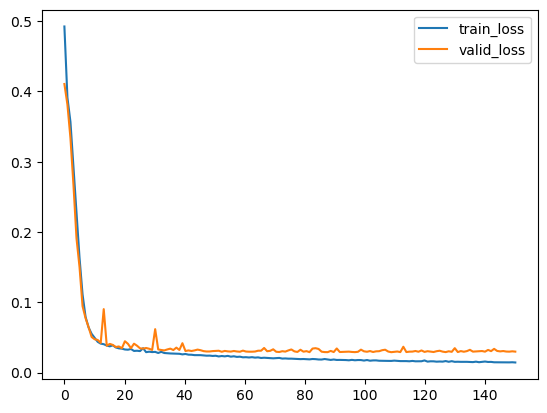

In [16]:
x = np.linspace(0, len(s_train_loss), len(s_train_loss))
plt.clf()
plt.plot(x, s_train_loss, label = 'train_loss')
plt.plot(x, s_valid_loss, label = 'valid_loss')

plt.legend()
plt.show()

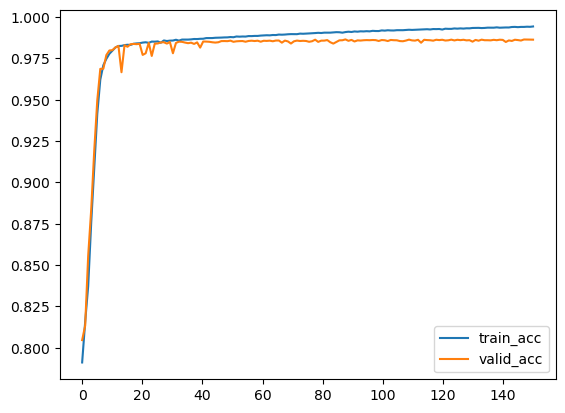

In [17]:
x = np.linspace(0, len(s_train_acc), len(s_train_acc))
plt.clf()
plt.plot(x, s_train_acc, label = 'train_acc')
plt.plot(x, s_valid_acc, label = 'valid_acc')

plt.legend()
plt.show()

In [18]:
# model = MLP().to(device)
# optim = torch.optim.Adam(model.parameters(), lr = 1e-4)

# for e in range(100):
#     t_loss = 0
#     t_acc = 0
#     v_loss = 0
#     v_acc = 0
    
#     model.train()
#     for (data, label) in tqdm(train_loader, desc = 'training'):
#         data  = data.to(device)
#         label = label.to(device)
#         pred = model(data)
#         loss = loss_func(pred, label)
#         loss.backward()
#         optim.step()
#         t_loss += loss.item()
#         t_acc += (torch.argmax(pred, axis = 1) == label).sum().item()
#     t_loss = t_loss / len(train_loader)
#     t_acc = t_acc / train_set.__len__()
#     model.eval()
#     with torch.no_grad():
#         for (data, label) in tqdm(valid_loader, desc = 'validating'):
#             data  = data.to(device)
#             label = label.to(device)
#             pred = model(data)
#             loss = loss_func(pred, label)
#             v_loss += loss.item()
#             v_acc += (torch.argmax(pred, axis = 1) == label).sum().item()
#     v_loss = v_loss / len(valid_loader)
#     v_acc = v_acc / valid_set.__len__()
        
#     print(f'epoch {e} | train_loss {t_loss:.6f} train_acc {t_acc:.6f} valid_loss {v_loss:.6f} valid_acc {v_acc:.6f}')

# 測試模型性能

In [19]:
import torcheval.metrics.functional as EF
import time

In [20]:
def testing_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        score = 0
        for (data, label) in tqdm(test_loader):
            data  = data.to(device)
            label = label.to(device)
            pred = model(data)
            score += EF.multiclass_f1_score(pred, label)
    f1_score = score / len(test_loader)
    end_time = time.time()
    return f1_score, (end_time - start_time)

In [21]:
#teacher_f1, teacher_time = testing_model(teacher_model, test_loader)
student_f1, student_time = testing_model(student_model, test_loader)
# f1 , time = testing_model(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████| 1710/1710 [00:14<00:00, 121.53it/s]


In [22]:
#print(teacher_f1, teacher_time)
print(student_f1, student_time)
# print(f1)

tensor(0.9781, device='cuda:0') 14.073099851608276